In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

This notebook is concerned with recreating the Sine tasks from the MAML paper, and training some nets to perform on them.

In [113]:
class Sine_Task():
    """
    A sine wave with interfaces designed for MAML
    """
    
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax
        
    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        
        return self.amplitude * np.sin(self.phase * x)
        
    def generate_data(self, size=1):
        """
        Generate data for this task.
        
        returns: 
            x: the feature vector of length size
            y: the target vector of length size
        """
        
        x = np.random.uniform(self.xmin, self.xmax, size)
        y = self.true_function(x)
        
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float).unsqueeze(1)
        
        return x, y

In [114]:
class Sine_Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """
    
    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        
    def generate_task(self):
        """
        Sample from the task distribution.
        
        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        return Sine_Task(amplitude, phase, self.x_min, self.x_max)

In [115]:
tasks = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)

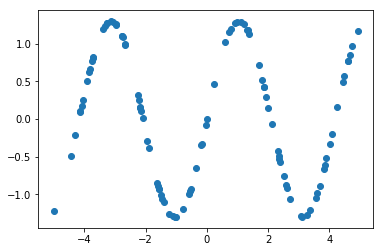

In [116]:
sine = tasks.generate_task()
plt.scatter(*sine.generate_data(100))

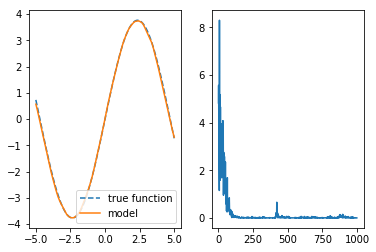

In [255]:
# set up model and task
model = nn.Sequential(
    nn.Linear(1,40),
    nn.ReLU(),
    nn.Linear(40,40),
    nn.ReLU(),
    nn.Linear(40,1)
)
task = tasks.generate_task()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# fit the model
losses = []

for i in range(1000):
    model.zero_grad()
    x, y = task.generate_data(10)
    y_hat = model(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    
# plot the result
x = np.linspace(-5, 5, 100)
y = model(torch.tensor(x, dtype=torch.float).view(-1, 1))


plt.subplot(1, 2, 1)
plt.plot(x, task.true_function(x), '--', label='true function')
plt.plot(x, y.detach().numpy(), label='model')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.show()

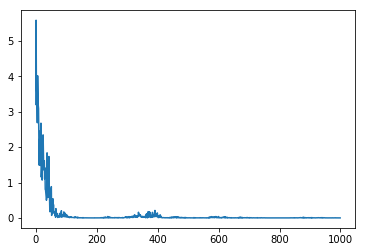